In [22]:
# Authors: Rahul Ramachandran and Rishit D

# Importing the required libraries
try:
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    import scipy
    import matplotlib.pyplot as plt
except:
    print(f'[INFO] Installing the required libraries')
    %pip install numpy, pandas, scikit-learn, scipy, matplotlib
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score
    from scipy.stats import poisson
    import matplotlib.pyplot as plt

In [36]:
from typing import List

class PoissonRegression:

    def __init__(self, dim:int, alpha:float=0.01, n_iter:int=1000, lambda_:float=0.1, weights:np.ndarray=None):
        """
            dim: Dimension of the data
            alpha: Learning rate
            n_iter: Max Number of iterations
            lambda_: Regularization parameter
            weights: Initial weights
        """
        if weights is not None:
            self.theta = weights # If weights provided, use them
            assert self.theta.shape == (dim+1, 1)
        else:
            self.theta = np.zeros((dim+1, 1)) # include the bias term
        self.alpha = alpha
        self.n_iter = n_iter
        self.lambda_ = lambda_
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        """Fits the model (theta) to the data
            params:
                X: shape = (n, dim)
                y: shape = (n, 1)
            returns:
                List of losses
                Weight vector theta
        """
        losses = []

        # Concatenate a column of ones to X
        X_c = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) # shape = (n, dim+1)

        for iter in range(self.n_iter):
            # Calculate the loss (ignore the constant factorial term)
            loss = -np.sum(y * (X_c @ self.theta) - np.exp(X_c @ self.theta)) + self.lambda_ * np.sum(self.theta**2)
            losses.append(loss)

            # Update theta (gradient descent)
            self.theta -= -self.alpha * (X_c.T @ (y - np.exp(X_c @ self.theta))) + 2 * self.lambda_ * self.theta
        
        return losses, self.theta
    
    def predict(self, X:np.ndarray)->np.ndarray:
        """Predicts the response variable
            params:
                X: shape = (n, dim)
            returns:
                y_pred: shape = (n, 1)
        """
        # Concatenate a column of ones to X
        X_c = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y_pred = np.exp(X_c @ self.theta)
        return y_pred

In [54]:
# Custom cross-validation for Poisson Regression
def cross_val_poisson(data, cv=5):
    """Performs cross-validation
        params:
            data: Dataframe
            cv: Number of folds
        returns:
            List of negative mean absolute errors
    """
    # Generate cross-val folds
    folds = np.array_split(data, cv)
    nmaes = []
    for i in range(cv):
        # Split into train and test
        test = folds[i]
        train = pd.concat([folds[j] for j in range(cv) if j != i])
        X_train, y_train = train[["Day","Company","Ordered","Event After"]].to_numpy(), train[["Duration"]].to_numpy()
        X_test, y_test = test[["Day","Company","Ordered","Event After"]].to_numpy(), test[["Duration"]].to_numpy()

        # Fit the model
        model = PoissonRegression(dim=4, alpha=1e-7, n_iter=100000, lambda_=1e-8, weights=np.array([[1., 0., 1., 1., -1.]]).T)
        losses, theta = model.fit(X_train, y_train)
        
        y_pred_pos = poisson.predict(X_test)
        nmae = -np.mean(np.abs(y_pred_pos - y_test))
        nmaes.append(nmae)
        
    return nmaes

In [57]:
# Get data from the csv file
df = pd.read_csv('final_data.csv')

# Randomly select 80% of the data for training
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)
X_train, y_train = np.array(train[["Day","Company","Ordered","Event After"]]), np.array(train["Duration"])[:, np.newaxis]
X_test, y_test = np.array(test[["Day","Company","Ordered","Event After"]]), np.array(test["Duration"])[:, np.newaxis]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 4) (60, 1) (15, 4) (15, 1)


-4214.8696236360665
[[ 2.69941828]
 [ 0.03182905]
 [ 0.64998092]
 [ 0.35137632]
 [-0.0190624 ]]
1.7471475539352412
7.820186667593065


/Users/rahulramachandran/anaconda3/envs/foml/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


-3.930818624051541


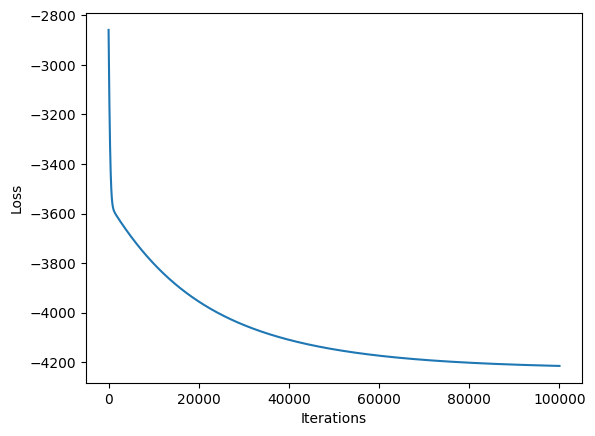

In [55]:
# Fit the model
poisson = PoissonRegression(dim=4, alpha=1e-7, n_iter=100000, lambda_=1e-8, weights=np.array([[1., 0., 1., 1., -1.]]).T)
losses, weights = poisson.fit(X_train, y_train)

# Plot the losses
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
print(losses[-1])
print(weights)

y_pred_pos = poisson.predict(X_test)

# Find mean absolute error on the test set
mae = np.mean(np.abs(y_pred_pos - y_test))
print(f'Mean Absolute Error: {mae}')

# Find mean squared error on the test set
mse = np.mean((y_pred_pos - y_test)**2)
print(f'Mean Squared Error: {mse}')

# Perform cross-validation
nmaes = cross_val_poisson(df, cv=5)
print(f'Cross Validation MAE (averaged over 5 runs): {-np.mean(nmaes)}')

In [49]:
# Fit linear regression
linear = LinearRegression()
vals = linear.fit(X_train, y_train)
print(vals.coef_, vals.intercept_)
y_pred_lin = linear.predict(X_test)

# Find mean absolute error on the test set
mae = np.mean(np.abs(y_pred_lin - y_test))
print(f'Mean Absolute Error: {mae}')
# Find mean squared error on the test set
mse = np.mean((y_pred_lin - y_test)**2)
print(f'Mean Squared Error: {mse}')

# Cross-validate
cv_results = cross_val_score(linear, train[["Day","Company","Ordered","Event After"]], train["Duration"], cv=5, scoring='neg_mean_absolute_error')
print(f'Cross Validation MAE (averaged over 5 runs): {-np.mean(cv_results)}')

[[ 0.5577566  12.32268965  6.98542006 -1.99081043]] [18.49151664]
2.637805350449054
10.122334268305982
-3.7421407706764604
